# Grid Forming Inverter Timeseries Forecasting

As we look to develop a 100% renewable power grid, there are challenges that many researchers and institutions (such as the National Renewable Energy Lab or Hodge Research Group here at CU) need to solve before this is possible. One of the largest challenges lies in the loss "inertia" in the dynamics of the AC power system. When we replace fossil fuels (typically with large spinning masses) for inverter-based solor photovoltaics, we lose inherent inertia that maintains the stability of the power system and prevents the power grid from cascading into massive blackouts. 

One of the leading proposed solutions for maintaining a stable power grid with a massive loss of inertia on the power grid, is to develop "grid forming inverters" for solar photovoltaics. These inverters would be able to read the parameters that indicate the state of the grid at the node that they are connected in the mesh network of transmission, and then adjust their behavior premptively to prevent cascading failures in frequency harmonics, voltage imbalances, or current surges. So how do we make these smart enough to make these predictions? This assignment shows how time series forecasting through deep learning tensorflow could be used to make these predictions by only reading the state of the grid at a singular node in the mesh transmission network. 

Please note to put this together, we followed very closely this tutorial https://www.tensorflow.org/tutorials/structured_data/time_series, but used power grid dynamics data (including voltage magnitude, voltage phase angle, current across the inverter circuit, and dynamics current magnitude swings) instead of the test dataset that the tutorial implements. For this week we just wanted to do some preliminary implementation of this scientific/engineering application of renewable grid modeling, so some of the blocks of our code are identical to those implemented in the tutorial. In future weeks, when we build out these smart predictive models for grid forming inverters, we will make sure and implement the full scripts ourselves. This notebook is basically a demonstration of the potential for this project using code from a different context of time series modeling. 

We have made sure to describe and interject our understanding and commments to show interaction and involved thinking even with the code blocks that are taken from the tutorial on time series forecasting.

In [19]:
import pandas as pd
import numpy as np
import scipy.interpolate as interp

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

### Read in and clean data
First step is to read in our data. This dataset is being used on a collaboritive project between NREL, CU, MIT, and Berkely to perform scientific machine learning for predictive modeling of grid forming inverters. Any code these teams have is written in Julia, so everything below is either from the tutorial we followed or written from scratch. In the code block below we interpolated the current data because the readings happen less frequently as voltage readings but we want to use current metrics as one of our parameters to train the model. 

10001
100
There is not enough Ir data
10001
10001
Now there is
        t        Vm    Vtheta        Ir        Ii
0  0.0000  1.021394 -0.300635  0.305384 -0.334257
1  0.0001  1.021394 -0.300635  0.305374 -0.334257
2  0.0002  1.021394 -0.300635  0.305364 -0.334257
3  0.0003  1.021394 -0.300635  0.305354 -0.334257
4  0.0004  1.021394 -0.300635  0.305344 -0.334257


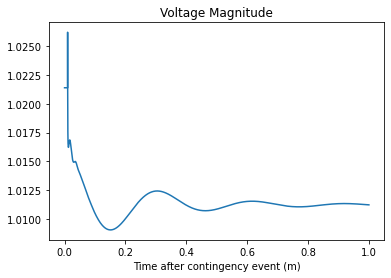

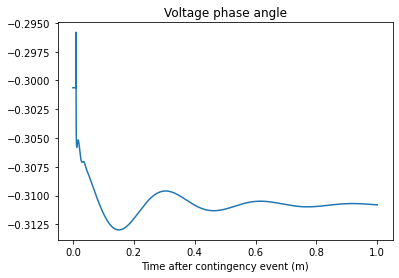

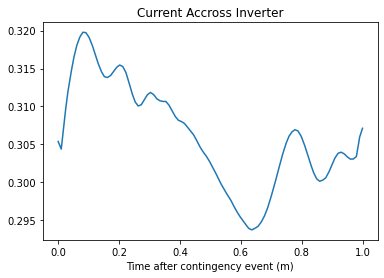

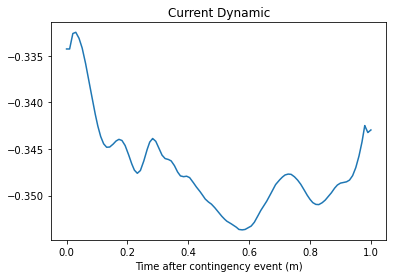

In [58]:
data=pd.read_excel('/Users/simon/Desktop/VIdata.xlsx', usecols=[0,1,2,6,7],skiprows=[0,1],names=['t','Vm','Vtheta','Ir','Ii'])

#Interpolating data for Ir to fit size of other dataset

arr_ref=data['t']
arr=data['Ir']
arr = arr[~np.isnan(arr)]
print(len(arr_ref))
print(len(arr))
print('There is not enough Ir data')
arr_interp = interp.interp1d(np.arange(arr.size),arr)
arr_stretch = arr_interp(np.linspace(0,arr.size-1,arr_ref.size))

print(len(arr_ref))
print(len(arr_stretch))
print('Now there is')
data['Ir']=arr_stretch


#Again for Ii

arr_ref=data['t']
arr=data['Ii']
arr = arr[~np.isnan(arr)]
#print(len(arr_ref))
#print(len(arr))
#print('There is not enough Ir data')
arr_interp = interp.interp1d(np.arange(arr.size),arr)
arr_stretch = arr_interp(np.linspace(0,arr.size-1,arr_ref.size))

#print(len(arr_ref))
#print(len(arr_stretch))
#print('Now there is')
data['Ii']=arr_stretch


print(data.head())
plt.plot(data['t'],data['Vm'])
plt.title('Voltage Magnitude')
plt.xlabel('Time after contingency event (m)')
plt.show()
plt.plot(data['t'],data['Vtheta'])
plt.xlabel('Time after contingency event (m)')
plt.title('Voltage phase angle')
plt.show()
plt.title('Current Accross Inverter')
plt.xlabel('Time after contingency event (m)')
plt.plot(data['t'],data['Ir'])
plt.show()
plt.title('Current Dynamic')
plt.xlabel('Time after contingency event (m)')
plt.plot(data['t'],data['Ii'])
plt.show()




In these plots, wer are looking at how the dynamics of the metrics of this node of the mesh transmission network change over time with time being measured as the time since a contingency event happens on the power grid. We can see how the harmonics of the system are oscillating and eventually find a new stability point for voltage magnitude and phase angle. If the grid forming inverters can predict what this point will be, the can adjust their behavior accordingly to help the grid regain control of harmonic propogation and reduce blackout risk.

In [60]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,10001.0,0.500000,0.288718,0.000000,0.250000,0.500000,0.750000,1.000000
Vm,10001.0,1.011441,0.001530,1.009044,1.011031,1.011265,1.011521,1.026216
Vtheta,10001.0,-0.310587,0.001530,-0.312985,-0.310998,-0.310764,-0.310507,-0.295812
Ir,10001.0,0.306154,0.006862,0.293731,0.301192,0.305643,0.311207,0.319778
Ii,10001.0,-0.347129,0.004845,-0.353692,-0.350474,-0.347986,-0.344790,-0.332461


### Correlation Analysis between variables
Below we have plotted the correlation map between the variables we will be training our data on. From these figures you begin to see how our model will be able to predict the phase angle (Vtheta) given the state of its current and voltage magnitude. We didn't plot time since the contingency event as a variable because that is basically shown in the figures above.

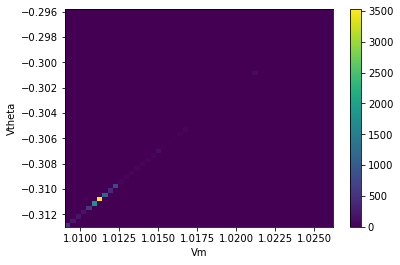

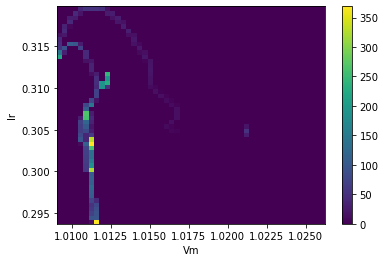

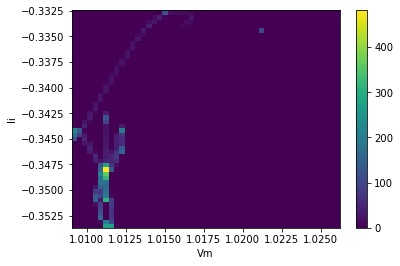

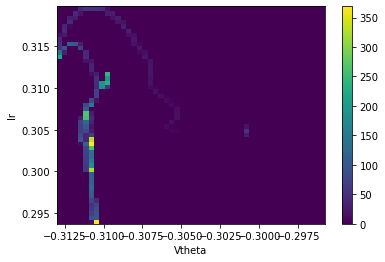

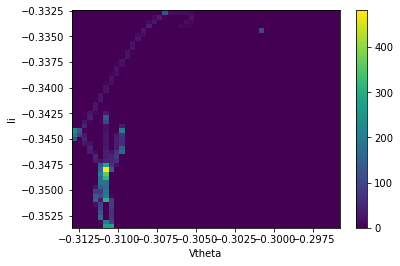

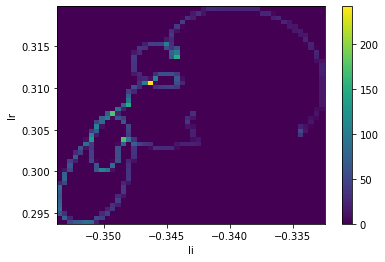

In [66]:
plt.hist2d(data['Vm'],data['Vtheta'],bins=(50,50))
plt.ylabel('Vtheta')
plt.xlabel('Vm')
plt.colorbar()
plt.show()
plt.hist2d(data['Vm'],data['Ir'],bins=(50,50))
plt.colorbar()
plt.ylabel('Ir')
plt.xlabel('Vm')
plt.show()
plt.hist2d(data['Vm'],data['Ii'],bins=(50,50))
plt.colorbar()
plt.ylabel('Ii')
plt.xlabel('Vm')
plt.show()
plt.hist2d(data['Vtheta'],data['Ir'],bins=(50,50))
plt.colorbar()
plt.ylabel('Ir')
plt.xlabel('Vtheta')
plt.show()
plt.hist2d(data['Vtheta'],data['Ii'],bins=(50,50))
plt.colorbar()
plt.ylabel('Ii')
plt.xlabel('Vtheta')
plt.show()
plt.hist2d(data['Ii'],data['Ir'],bins=(50,50))
plt.colorbar()
plt.ylabel('Ir')
plt.xlabel('Ii')
plt.show()

### Train data

In [70]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df= data[int(n*0.9):]

num_features = data.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

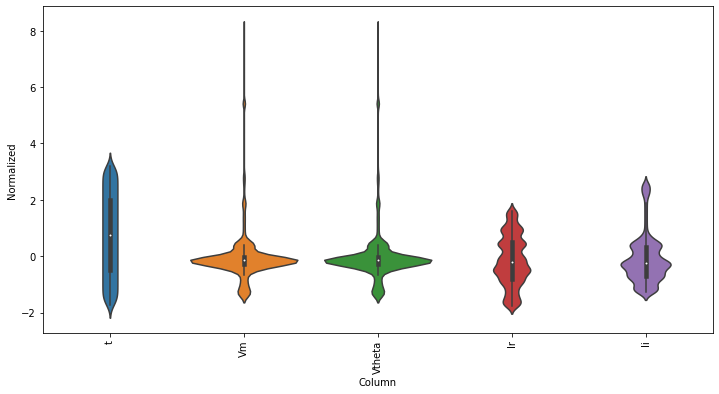

In [72]:
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

The above figure shows the normalized distributions of the data. As we previously investigated in a different section of this biweekly report, normalized input data (we used batch normalization) improves the accuracy of the training set because the loss function can find its root much faster and more reliably. 

In [85]:
class WindowGenerator():
      def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
              self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        def __repr__(self):
            return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])
        def split_window(self, features):
            inputs = features[:, self.input_slice, :]
            labels = features[:, self.labels_slice, :]
            if self.label_columns is not None:
                labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

            # Slicing doesn't preserve static shape information, so set the shapes
            # manually. This way the `tf.data.Datasets` are easier to inspect.
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])
            return inputs, labels

WindowGenerator.split_window = split_window

In [90]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Vtheta'])
w1
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Vtheta'])
w2

This window generator class is taken directly from the tutorial because it allows us to display or dynamic results nicely.

In [91]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
Labels shape: (3, 1, 1)


In [92]:
w2.example = example_inputs, example_labels

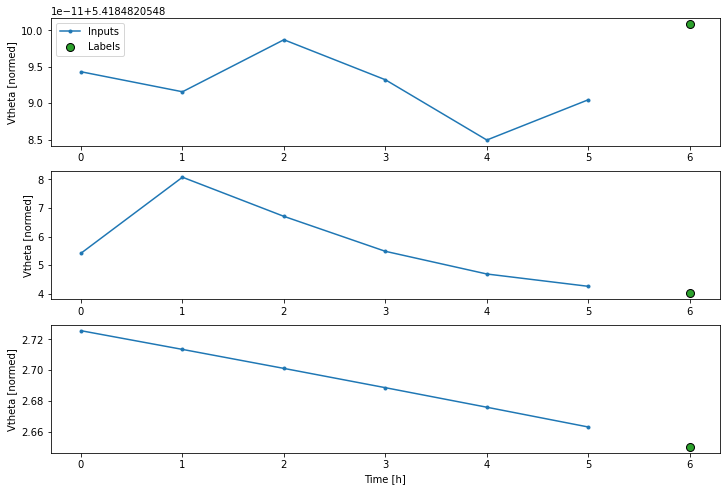

In [95]:
def plot(self, model=None, plot_col='Vtheta', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot
w2.plot()

These figured are demonstrating how we plan to perform this time series prediciton. With our training set (in blue) we should be able to use a model to predict a value that is close to the green dot. Eventually, we will be able to predict multiple green dots into the future and our grid forming inverter will be on its way to predicting harmonic swings of it's node of the mesh transmission system.


#### Implementing Keras timeseries_dataset_from_array model functionality

In [97]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [98]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [99]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [101]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [102]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Vm'])
single_step_window

In [103]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


### Beginning TensorFlow and Keras implementation of models for predictive time-series learning

In [104]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [114]:
baseline = Baseline(label_index=column_indices['Vtheta'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 1ms/step - loss: 2.0254e-08 - mean_absolute_error: 1.2839e-04


In [122]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Vtheta'])

wide_window

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


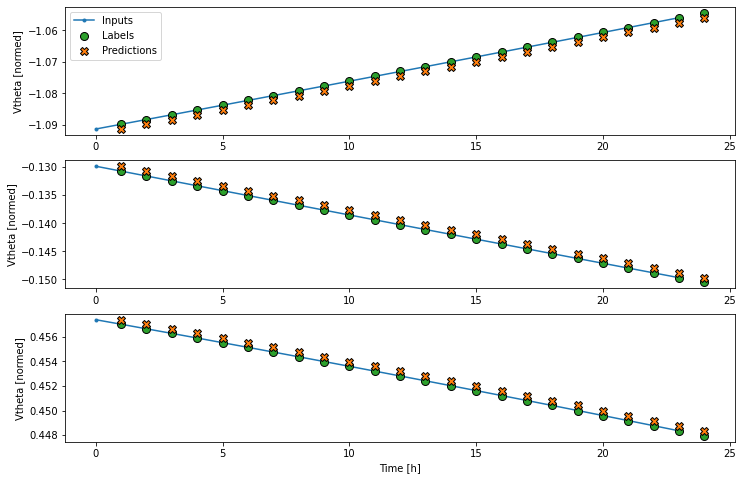

In [123]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(baseline)

The above visuals were developed in the tutorial and applied to the state of our dataset. Here, by using MSE as our loss function metric, we are fiting a baseline prediction model to our initial inputs of the time series. We will require further investigation to see how this will perform amongst the other variables (here we used the phase angle Vtheta) and less linear changes in behavior, however we can see that our fitting baseline is good.

#### Developing model and putting to the test

In [125]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [127]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [128]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2531 - mean_absolute_error: 0.4147 - val_loss: 0.2774 - val_mean_absolute_error: 0.4964
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0408 - mean_absolute_error: 0.1658 - val_loss: 0.5250 - val_mean_absolute_error: 0.7051
Epoch 3/20
63/63 [==============================] - 0s 1ms/step - loss: 0.5628 - mean_absolute_error: 0.7327


Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


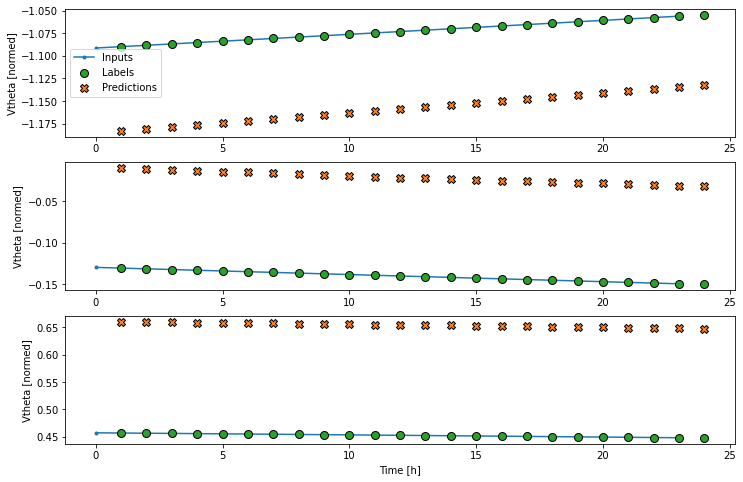

In [141]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)

In these figures we are testing how our predictive models align with the "labels" set, which is corresponding to a test data set. We can see that the trends in the dynamics of the data look reasonably accurate, but the magnitude of our projections are wrong. This will require further debugging and trails for us to fix, and we haven't gotten around to it at this stage in our Bi-weekly progress. Since this error seems so systematic, one could obviously hard-code the difference within the smart grid forming inverters (it seems to understand the dynamics) but we wan't these fits to be as strong as possible from the predictive models so they have the ability to handle more extreme "worst case senarios" on the power grid

### Prediction

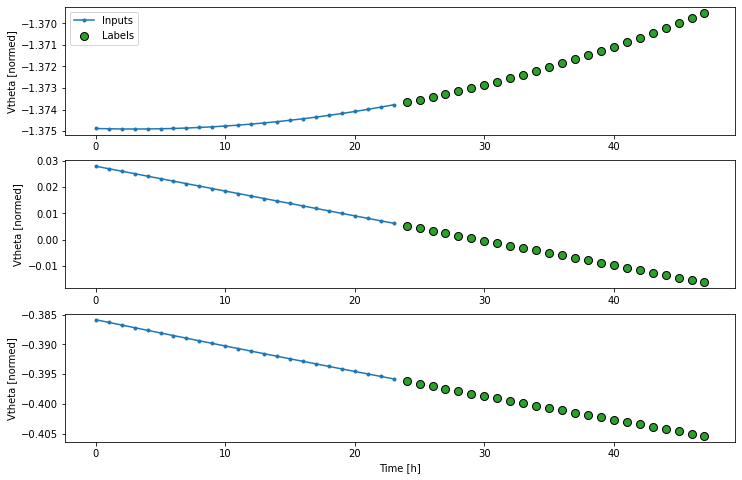

In [131]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

62/62 [==============================] - 0s 1ms/step - loss: 2.6743e-04 - mean_absolute_error: 0.0118


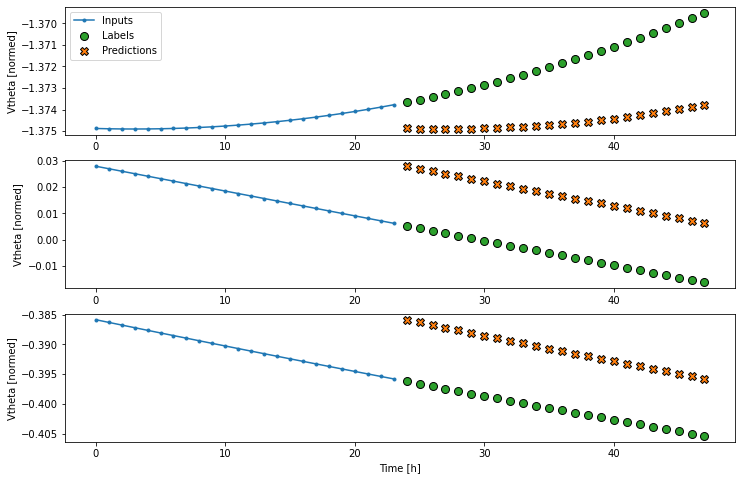

In [135]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}



multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Although we had some error in the previous section, we used the code from the tutorial just to show you what we plan to do in this predictive time series dynamics modeling. As you can see we will be able to use the inputted trained data as the initial interpretation of the grid-forming inverter that a contingency event has occured. Then, with accurate clean models, the grid forming inverter should be able to predict the dynamcics and harmonic swings of its components accurately. This will allow it to adjust accordingly and maintin stability in the grid. If photovoltaic and battery storage devices had these smart features in their inverters, we would be very close to having the technology ready to operate and maintain a 100% renewable power grid that is equally as reliable and stable as the one we know today (maybe even more so because computational decision making is faster than the inertia response of spinning masses in fossil fuel plants)!

As mentioned before, in the next few weeks we will likely dive deeper into this application of predictive grid forming inverters by developing models from scratch with tensor flow and hopefully attaining simulated results (obviously without implanting it into actual power hardware) that are competative with the current technology of fossil fuels and/or cutting edge smart inverter systems that exist today!